In [5]:
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras
import numpy as np 
import seaborn as sns 
import nltk as nlp
import string
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [6]:
plt.rc("font",size = 15)
sns.set(style="dark")
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(10,10)})
%matplotlib inline
pd.set_option('display.max_columns',500)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
plt.style.use('fivethirtyeight')

In [7]:
#import 
income = pd.read_csv('gm_income.csv')
cf =pd.read_csv('gm_cf.csv')
bal = pd.read_csv('gm_balance.csv')

# Initial Analysis 

## Purpose 
<br> 

I made this analysis in order to show my work flow and methods, and so I also included the reasons behind the tools I used and why I believed them to be statistically valid. 

I focused mainly on a simple analysis of the company and I would add the following sections to a more detailed one: 

1) Qualitative analysis: reading through 10-ks and SEC filings to get a more comprehensive view of the company 

2) Valuation methods: I used here a simple cash flow based valuation and I discuss below how more detailed valuations would be done 

3) Models: I used a simpler forecasting model here, and I would usually want to compare results of several models and use extrinsic variables along side historical data 


4) Margins of Safety: I would normally attempt to condense the confidence interval so that our valuation is more accurate. I used here a 95% confidence interval which ended up having a wide range, a more detailed analysis would allow us to condense that range.


## Initial Observations and Assumptions
<br> 
GM was the company we chose for this high level analysis and valuation, partly due to its longevity and predictability, and mainly due to the availability of the data. 

1) We successfully imported our financial statements, and our data for the cash flows and balance sheet goes back to Q1 of 2011. Unfortunately, only data going back to Q1 of 2016 was found for our income statements which might make our sale analysis less powerful/accurate



2) We will have to perform quite a bit of preprocessing to handle missing values, reformat our dates, and create columns that are easier to work with 



3) We were able to choose only the relevant information through Sentieo for our somewhat high level analysis: 



Our Income statement will be focused on sales, operating, and net incomes with no detailed analysis for operational costs and corporate structure; we end up with 39 features work with 


Our cash flow statement was broken down to operational cash flows and capital expenditures so that we can arrive at a simple estimation of distributable cash flows. We arrive at 18 features to analyze after filtration.


Our Balance sheet was trimmed down to the high level essentials; mainly the ability of the company to handle long and short term difficulties and its fundamental debt structure. Secondly we will analyze the company through its reported book value rather than the reproduction cost of the assets for an incoming competitor, this again is done for the sake of simplicity. Here we arrive at 39 features to work through for our analysis. 

<br>

In [8]:
#quick set analysis and transposing so that we have date rows 
def quick_anal(df): 
    print('Data Types: \n',df.dtypes)
    print('\nData Shape: \n',df.shape)
    print('\nOverall Info: \n', df.info())
    print('\nNull Values: \n', df.isna().sum())
def trans(df): 
    df.set_index('Row Label',inplace = True) 
    df = df.T 
    return df 
income,cf, bal= trans(income),trans(cf),trans(bal)

## Data Information 

In [9]:
print('Overview Of Income Statement:\n')
print(quick_anal(income))


Overview Of Income Statement:

Data Types: 
 Row Label
Period End Date                                                     object
SEC Document Type                                                   object
Missing Column Data Code                                            object
NaN                                                                 object
Net sales and revenue                                               object
Automotive                                                          object
GM Financial                                                        object
Total net sales and revenue (Note 3)                                object
Costs and expenses                                                  object
Automotive and other cost of sales                                  object
GM Financial interest, operating and other expenses                 object
Automotive and other selling, general and administrative expense    object
Total costs and expenses                     

# Data Cleaning and Preprocessing 
<br>

## Process:

<br> 
Our clean up required us to do the following: 
<br> 

1) Rename our columns and format them for ease of usage 


2) Remove columns which only contained missing values 


3) Remove unnecessary rows and create a proper date index for each filing date 


4) Conversion of our data to numbers 



## Results: 

<br> 
After Preprocessing our data is as follows: 

1) All of our statements now contain valid data, and all of the necessary components for our analysis contain no missing values 


2) Our income statement now contains 35 components, our cash flows 14, and our balance sheet 14 as well.
<br>

In [10]:
#preprocessing and cleaning steps 


def preprocess_cols(df): 
    
    cols = df.columns.tolist()
    cols = [str(x) for x in cols]
    #lower case, replace - with _, replace space with _ 
    cols = [re.sub(r'\([^)]+\)','',x) for x in cols]
    cols = [x.strip().lower().replace('-','_').replace(' ','_').replace('\'','') for x in cols]
    df.columns= cols 
    return df

def preprocess_rows(df):
    #dropping unwanted rows and columns 
    to_drop_cols = ['sec_document_type','missing_column_data_code','nan']
    rows = df.index.tolist()
    to_drop_rows = [x for x in rows if x.startswith('FY')]
    df.drop(to_drop_cols,axis= 1,inplace = True)
    df.drop(to_drop_rows,axis = 0,inplace =True)
    
    
    #setting proper index: 
    df['period_end_date'] = pd.to_datetime(df['period_end_date'])
    df.reset_index(drop = True)
    df.set_index('period_end_date',inplace = True)
    
    #trnsformations 
    df = df.transform(lambda x: x.apply(lambda y:re.sub(r'[^-\d]','',str(y))))
    df = df.transform(lambda x: x.str.replace(',','').replace('',np.nan).replace('--',np.nan))
    df = df.applymap(lambda x: float(x))
    
    
    #finally dropping columns with all missing values  
    
    all_null_cols = df.loc[:,df.isna().all()].columns.tolist()
    df.drop(all_null_cols, axis = 1,inplace = True)
    
    return df 

def noise_removal(df): 
    df = preprocess_cols(df)
    df = preprocess_rows(df)
    return df
   

In [11]:
#appplying transformations 
income = noise_removal(income)
cf = noise_removal(cf)
bal = noise_removal(bal)

## Descriptive Statistics 
<br> 
Below we create an overview of centrality and dispersion measures for our statements. 

Of note is that since 2016 we have had average quarterly sales of 37 billion, with a fairly low deviation. 

Our earnings have also been consistent at around 1.7 billion, meaning that we can expect a 4% profit margin on average, which is higher and more stable than most in the automotive industry. 


We observe similar consistencies in our cash flows and balance sheets suggesting that we have a disciplined and long-term oriented management. 



In [12]:
def describ_stats(df,typ): 
    print(f'{typ} Statistics: \n')
    display(df.describe()) 

In [13]:
#stats
describ_stats(income, 'Income Statement')
describ_stats(cf,'Cash Flow Statement')
describ_stats(bal, 'Balance Sheet')

Income Statement Statistics: 



,automotive,gm_financial,total_net_sales_and_revenue,automotive_and_other_cost_of_sales,"gm_financial_interest,_operating_and_other_expenses","automotive_and_other_selling,_general_and_administrative_expense",total_costs_and_expenses,operating_income,automotive_interest_expense,"interest_income_and_other_non_operating_income,_net",equity_income,income_before_income_taxes,income_tax_expense,net_income,net_loss_attributable_to_noncontrolling_interests,net_income_attributable_to_stockholders,net_income_attributable_to_common_stockholders,basic_earnings_per_common_share,weighted_average_common_shares_outstanding___basic,diluted_earnings_per_common_share,weighted_average_common_shares_outstanding___diluted,dividends_declared_per_common_share,income_from_continuing_operations,loss_from_discontinued_operations_net_of_tax,basic_earnings_per_common_share___continuing_operations,basic_loss_per_common_share___discontinued_operations,diluted_earnings_per_common_share___continuing_operations,diluted_loss_per_common_share___discontinued_operations
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,8.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.0,8.000000,3.000000,8.000000,3.000000,8.000000,3.000000
mean,33946.307692,3133.615385,37079.923077,29912.692308,2796.538462,2400.538462,35109.769231,1970.153846,161.076923,341.153846,460.384615,2610.615385,625.384615,1682.461538,15.153846,1276.125000,1680.538462,114.076923,1463.000000,112.384615,1485.076923,38.0,1926.500000,-1265.333333,134.125000,-86.666667,132.500000,-85.666667
std,3573.779824,550.764248,3165.998459,2696.933208,459.789375,311.191692,2614.878874,833.418347,24.968185,301.403342,213.656866,811.501955,556.678025,1575.658466,18.769861,1897.320775,1581.125159,107.931662,57.338178,106.310503,62.607856,0.0,860.927905,1640.093087,59.757695,113.773166,59.020578,112.095198
min,29150.000000,2070.000000,32709.000000,26511.000000,1886.000000,1970.000000,31707.000000,529.000000,127.000000,-49.000000,-132.000000,643.000000,100.000000,-2982.000000,-9.000000,-2981.000000,-2983.000000,-206.000000,1408.000000,-203.000000,1430.000000,38.0,114.000000,-3096.000000,8.000000,-214.000000,8.000000,-211.000000
25%,31817.000000,2875.000000,35473.000000,28229.000000,2666.000000,2102.000000,33573.000000,1477.000000,147.000000,161.000000,414.000000,2430.000000,357.000000,1663.000000,4.000000,858.000000,1660.000000,111.000000,1417.000000,109.000000,1436.000000,38.0,1886.250000,-1933.000000,132.000000,-132.500000,130.250000,-131.000000
50%,32691.000000,3408.000000,36099.000000,29212.000000,2987.000000,2372.000000,34366.000000,1972.000000,151.000000,172.000000,530.000000,2630.000000,524.000000,2311.000000,12.000000,2254.000000,2313.000000,162.000000,1433.000000,160.000000,1442.000000,38.0,2338.500000,-770.000000,162.000000,-51.000000,160.000000,-51.000000
75%,35195.000000,3559.000000,37265.000000,30589.000000,3064.000000,2684.000000,35570.000000,2618.000000,181.000000,549.000000,560.000000,2967.000000,700.000000,2530.000000,22.000000,2397.000000,2503.000000,173.000000,1505.000000,170.000000,1532.000000,38.0,2410.500000,-350.000000,168.000000,-23.000000,166.000000,-23.000000
max,40334.000000,3656.000000,42825.000000,34778.000000,3356.000000,2847.000000,39808.000000,3036.000000,206.000000,930.000000,660.000000,3721.000000,2316.000000,2850.000000,61.000000,2534.000000,2866.000000,185.000000,1550.000000,181.000000,1581.000000,38.0,2530.000000,70.000000,177.000000,5.000000,175.000000,5.000000


Cash Flow Statement Statistics: 



,"depreciation_and_impairment_of_equipment_on_operating_leases,_net","depreciation,_amortization_and_impairment_charges_on_property,_net",foreign_currency_remeasurement_and_transaction__losses,net_cash_provided_by__operating_activities,expenditures_for_property,"available_for_sale_marketable_securities,_acquisitions","available_for_sale_marketable_securities,_liquidations",net_cash_used_in_investing_activities,net_increase_in_short_term_debt,proceeds_from_issuance_of_debt,payments_on_debt,dividends_paid,net_cash_provided_by_financing_activities,"cash,_cash_equivalents_and_restricted_cash_at_beginning_of_period"
count,6.000000,13.000000,13.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,3730.000000,4333.615385,88.692308,5292.785714,-3691.321429,-4002.785714,4315.928571,-8498.107143,215.857143,16183.357143,-10530.714286,-935.607143,4532.107143,16398.500000
std,1678.099878,2200.936904,161.931253,3871.771241,1719.273211,3686.949993,2703.301711,6289.696609,520.634991,11829.186094,8065.959234,538.026183,5540.980815,6289.685852
min,1806.000000,1502.000000,-178.000000,-377.000000,-6906.000000,-16349.000000,678.000000,-24124.000000,-936.000000,144.000000,-29432.000000,-1792.000000,-2345.000000,195.000000
25%,2353.500000,2883.000000,-12.000000,1872.250000,-4911.250000,-4583.250000,2447.000000,-11348.500000,-148.500000,6037.000000,-14167.000000,-1274.500000,680.000000,15238.000000
50%,3735.500000,3775.000000,106.000000,5759.000000,-3661.000000,-2648.000000,3649.500000,-6813.500000,119.500000,12465.500000,-9399.500000,-664.000000,2839.000000,17848.000000
75%,5116.750000,5259.000000,237.000000,7975.750000,-2011.750000,-1738.250000,6388.250000,-4491.750000,492.250000,23613.750000,-4592.250000,-546.500000,6948.250000,19220.750000
max,5633.000000,9084.000000,280.000000,12529.000000,-1224.000000,-564.000000,10351.000000,39.000000,1695.000000,43048.000000,-253.000000,-217.000000,23680.000000,23496.000000


Balance Sheet Statistics: 



,cash_and_cash_equivalents,marketable_debt_securities,"accounts_and_notes_receivable,_net","gm_financial_receivables,_net",inventories,other_current_assets,total_current_assets,"gm_financial_receivables,_net",equity_in_net_assets_of_nonconsolidated_affiliates,"property,_net","goodwill_and_intangible_assets,_net","equipment_on_operating_leases,_net",deferred_income_taxes,other_assets,total_non_current_assets,total_assets,accounts_payable,automotive,gm_financial,accrued_liabilities,total_current_liabilities,automotive,gm_financial,postretirement_benefits_other_than_pensions,pensions,other_liabilities,total_non_current_liabilities,total_liabilities,retained_earnings,accumulated_other_comprehensive_loss,total_stockholders_equity,non_current_assets_held_for_sale,restricted_cash,other_liabilities,non_current_liabilities_held_for_sale
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,21.000000,25.00000,26.000000,25.00000,28.000000,28.000000,28.00000,28.000000,28.000000,28.000000,28.000000,25.000000,28.000000,28.000000,28.000000,19.000000,28.000000,28.000000,28.000000,28.000000,28.000000,14.000000,15.000000,14.000000,2.0000
mean,18717.571429,8433.357143,10787.750000,16338.214286,13796.285714,3363.000000,77537.964286,16674.000000,8231.892857,30542.428571,4677.904762,22785.96000,16452.730769,3792.40000,114481.250000,193303.535714,25489.25000,15965.928571,17596.392857,26851.535714,72094.571429,9344.360000,32806.321429,6374.071429,18596.000000,10856.000000,78624.892857,151589.071429,16986.500000,-6537.642857,40412.535714,15084.071429,885.600000,12381.285714,10333.5000
std,4728.895803,2256.725819,1403.053908,7670.166787,1814.820731,1992.037297,8248.354496,6743.089697,873.023878,6110.306172,2222.658496,17993.05788,12588.885465,2037.79186,32699.394002,33925.286647,2045.53906,42451.373084,11586.466196,2133.605946,13096.426124,5140.164588,20494.540769,1131.722186,5379.961269,4538.049434,21260.200090,32587.776368,7584.009003,3417.304030,3422.259298,11270.661331,300.450804,2745.510305,5599.5786
min,12792.000000,4247.000000,6924.000000,3314.000000,10799.000000,1485.000000,62949.000000,6162.000000,6793.000000,19944.000000,676.000000,1066.00000,713.000000,785.00000,71370.000000,145846.000000,20031.00000,411.000000,1265.000000,22450.000000,51682.000000,3263.000000,5046.000000,5301.000000,10223.000000,430.000000,42877.000000,102881.000000,1951.000000,-11800.000000,34298.000000,4508.000000,581.000000,4490.000000,6374.0000
25%,15893.000000,6874.250000,10372.500000,10378.250000,11707.000000,1767.250000,71334.750000,10653.750000,7510.500000,26023.000000,5225.000000,3726.00000,1538.000000,2377.00000,84861.000000,161196.500000,24635.00000,798.750000,8250.500000,25183.500000,59421.500000,6687.000000,13224.250000,5756.000000,13891.500000,12103.000000,60883.250000,121939.500000,12026.500000,-8208.500000,37942.500000,9428.000000,623.000000,12739.750000,8353.7500
50%,18247.500000,8193.500000,10830.500000,17074.500000,14527.000000,2098.500000,77181.500000,17474.000000,8257.000000,28906.000000,5720.000000,24538.00000,23263.500000,3688.00000,103958.500000,187406.000000,25529.00000,1458.500000,15777.000000,26994.000000,72543.000000,9544.000000,31143.500000,5842.500000,18876.000000,12743.000000,80870.000000,152003.500000,14868.500000,-7929.000000,40848.500000,9923.000000,786.000000,12869.000000,10333.5000
75%,20311.500000,9661.250000,11610.250000,21369.000000,15212.500000,4888.000000,82563.500000,22244.500000,8796.000000,37231.750000,6083.000000,41775.00000,24406.500000,5169.00000,149409.500000,226658.750000,26967.25000,2569.250000,26080.250000,28185.000000,83066.000000,11012.000000,53283.000000,6774.250000,22184.250000,13076.000000,99852.000000,183595.750000,24011.750000,-5938.250000,42862.500000,11271.750000,1109.000000,13598.750000,12313.2500
max,38506.000000,14686.000000,13015.000000,28017.000000,15844.000000,7451.000000,97699.000000,26264.000000,9883.000000,38655.000000,6433.000000,44128.00000,34263.000000

# Sales Analysis 

<br> 
## Assumptions: 




Since quarterly data will not be enough to fully analyze the year's performance, we interpolated our existing quarterly sales and up-sampled them to produce monthly data. We did this by assuming some sort of relationship amongst  the months of the quarter and using derivatives to identify a likely relationship such that our monthly sales add up to our quarterly. Although having the actual monthly data would allow for a more comprehensive analysis of potential trends and fluctuations of sales, I believe that our assumptions are reasonable and our bias is not too significant.


<br>

## Trends and Results: 

<br>

1) The seasonal nature of our sales suggests that the majority of sales are coming from automotive sales 


2) The lasting seasonal pattern also suggests that GM's other products such as the sales of parts, GM financial, and technology will not be a major portion of sales any time soon. 



3) Our Sales have a consistent downward trend over the years (probably explained by lack of significant moat and high competition). 


4) We conclude through our residuals that sales are indeed predictable and stable year over year despite the downward trend indicating no change or worsening in the internal foundation of the company but rather an increase in external difficulties. 




In [14]:
month_sales = (income['total_net_sales_and_revenue']/3).resample('M').interpolate(method = 'from_derivatives')

In [15]:
#peak at 2017 sales 
month_sales['2017':'2018']

period_end_date
2017-01-31    13908.928571
2017-02-28    13825.595238
2017-03-31    13733.333333
2017-04-30    13270.036630
2017-05-31    12791.296703
2017-06-30    12328.000000
2017-07-31    11950.496377
2017-08-31    11572.992754
2017-09-30    11207.666667
2017-10-31    11348.245421
2017-11-30    11484.289377
2017-12-31    11624.868132
2018-01-31    11765.446886
2018-02-28    11892.421245
2018-03-31    12033.000000
2018-04-30    12105.637363
2018-05-31    12180.695971
2018-06-30    12253.333333
2018-07-31    12144.496377
2018-08-31    12035.659420
2018-09-30    11930.333333
2018-10-31    11878.496337
2018-11-30    11828.331502
2018-12-31    11776.494505
Freq: M, Name: total_net_sales_and_revenue, dtype: float64

## Visualizing Sales 
<br> 

The following patterns appear upon visualization: 

1) The time series has a seasonality pattern; sales are high at the beginning of the year and taper off towards the end (to be expected in the automotive industry).


2) There is always an uptrend for the first few months within any single year followed by low months half-way through the year.


3) Most significantly is that we observe an overall downward trend over the years, due to the lack of data pre-2016, we will attempt to decompose the time series to determine the chances that this trend is an outlier and not indicative of the future 

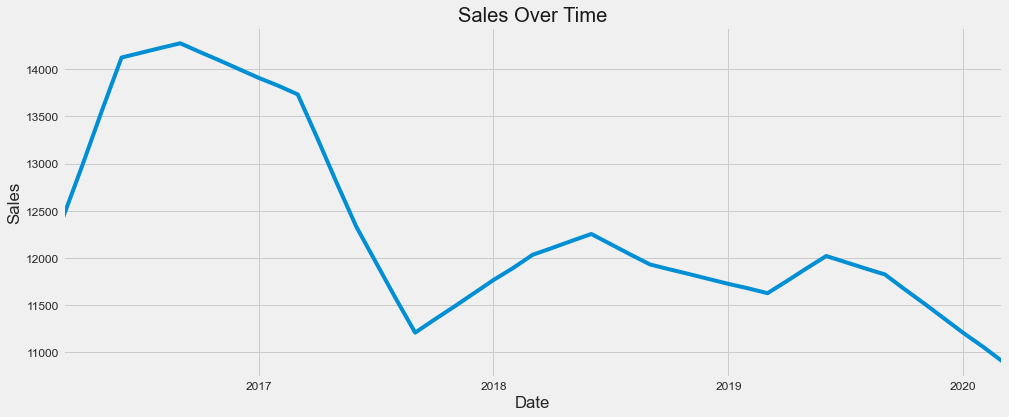

In [16]:
#plotting
plt.figure(figsize= (15,6))
month_sales.plot()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time')
plt.show()

### Decomposition: 

<br>

The figures below represent the three primary components of our time series; seasonality, trend, and noise: 

<br>
1) As our previous observations suggest, we unfortunately observe a consistent downward trend over the years even if the 2016 data was an outlier

<br>


2) Our seasonality component confirms our earlier observations that sales are indeed seasonal and that they are higher in the beginning of the year 



3) The apparent pattern in our residuals suggests that despite of the seasonality factor, our sales are quite stable and predictable.

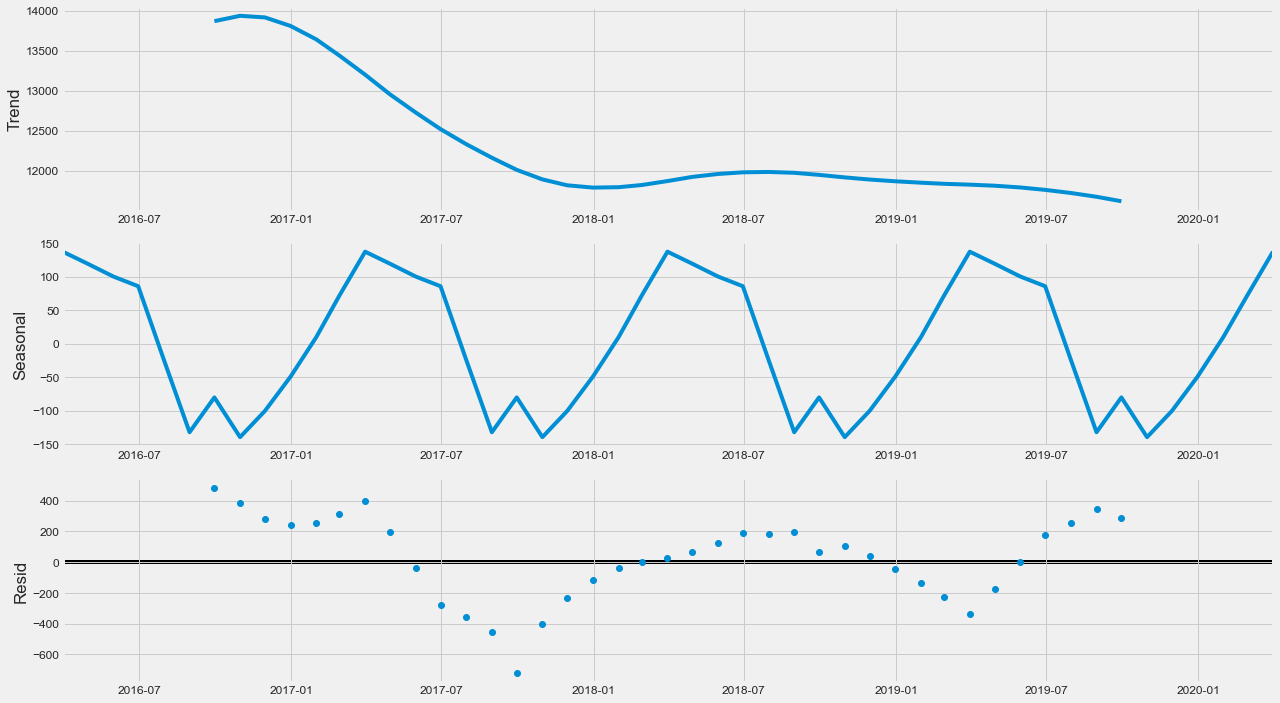

In [17]:
#plotting 
plt.rcParams['figure.figsize'] = 18,10
decompose = sm.tsa.seasonal_decompose(month_sales,model='additive')
fig = decompose.plot(observed = False)
plt.show()

# Debt analysis
<br> 


## debt structure: 
<br>
1) We now begin to get a full picture of what was happening pre 2016; our debt was almost 4 times our equity prior to 2012, following that we see a tremendous decline in our debt, followed by another gradual debt increase characteristic of expansion, and we are now back at similar debt levels.  



2) If it's true that GM was encountering difficulties pre-2012 as suggested by their debt levels, it may be the case that they are heading into a very similar situation. 



3) The above point may be unlikely when we look at our debt to assets; pre 2012, GM's debt was slightly greater than assets, this time around they were seemingly able to expand intelligently as evident by our debt averaging 46% assets over the past three years 

## Short Term Flexibility:


Through the analysis of GM's short-term cash generation capabilities, we note that they seem to have always maintianed a culture of preparedness, we infer this from operating incomes being consistently over 12 times interest and the current ratio consistently above 1

<br>



In [18]:
#calculations 

bal['debt'] = bal['gm_financial'].sum(axis =1 ) + bal['automotive'].sum(axis =1 )  
bal['debt_equity'] = bal['debt'] / bal['total_stockholders_equity']
bal['debt_assets'] = bal['debt'] / bal['total_assets']
bal['current'] = bal['total_current_assets'] / bal['total_current_liabilities']
bal['intCov'] = income['operating_income'] / income['automotive_interest_expense']


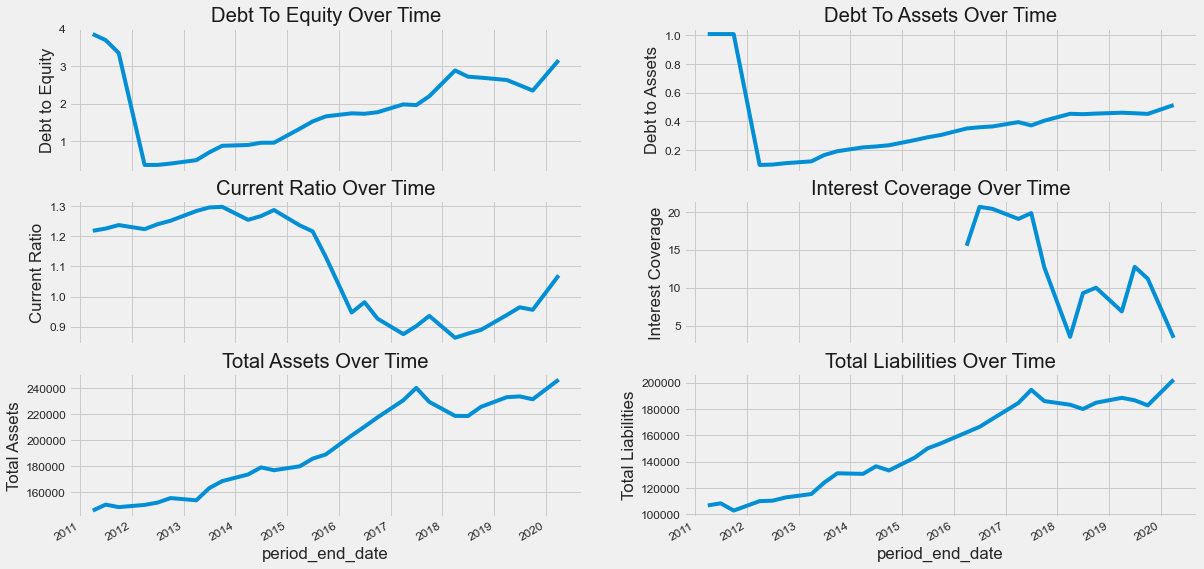

In [19]:
#visualize
fig, axs = plt.subplots(3,2,sharex= True, figsize= (18,10))
bal['debt_equity'].plot(ax = axs[0,0])
axs[0,0].set_ylabel('Debt to Equity')
axs[0,0].set_title('Debt To Equity Over Time') 

bal['debt_assets'].plot(ax= axs[0,1])
axs[0,1].set_ylabel('Debt to Assets')
axs[0,1].set_title('Debt To Assets Over Time')


bal['current'].plot(ax= axs[1,0])
axs[1,0].set_ylabel('Current Ratio')
axs[1,0].set_title('Current Ratio Over Time')

bal['intCov'].plot(ax= axs[1,1])
axs[1,1].set_ylabel('Interest Coverage')
axs[1,1].set_title('Interest Coverage Over Time')


bal['total_assets'].plot(ax= axs[2,0])
axs[2,0].set_ylabel('Total Assets')
axs[2,0].set_title('Total Assets Over Time')


bal['total_liabilities'].plot(ax= axs[2,1])
axs[2,1].set_ylabel('Total Liabilities')
axs[2,1].set_title('Total Liabilities Over Time')

plt.show()

## Balance Sheet Growth Over Time

In [20]:
def growth(df,typs,cols): 
    for typ,col in zip(typs,cols):
        print('\n')
    
        if typ.lower().endswith('ratio') or typ.lower().startswith('total'):
            print(f'The median {typ} was {df[col].median():.3f} with an average growth rate of {df[col].pct_change().median():.3%}')
        else: 
            print(f'The median {typ} was {df[col].median():.3%} with an average growth rate of {df[col].pct_change().median():.3%}')
            
    print("\nThree Year Trend Progression: \n")
    display(df[cols].resample('3Y').mean())
growth(bal,['Debt to equity', 'Debt to assets','Current ratio','Interest coverage ratio','Total Asset Value','Total Liabilities Value'],['debt_equity','debt_assets','current','intCov','total_assets','total_liabilities'])               



The median Debt to equity was 175.350% with an average growth rate of 2.459%


The median Debt to assets was 36.073% with an average growth rate of 3.837%


The median Current ratio was 1.174 with an average growth rate of 0.936%


The median Interest coverage ratio was 12.689 with an average growth rate of -3.893%


The median Total Asset Value was 187406.000 with an average growth rate of 3.006%


The median Total Liabilities Value was 152003.500 with an average growth rate of 2.480%

Three Year Trend Progression: 



,debt_equity,debt_assets,current,intCov,total_assets,total_liabilities
period_end_date,,,,,,
2011-12-31,3.629296,1.008594,1.226779,NaN,148252.666667,106008.000000
2014-12-31,0.665654,0.160802,1.266498,NaN,163630.333333,122734.000000
2017-12-31,1.763317,0.344360,1.017055,18.025055,209663.111111,168175.666667
2020-12-31,2.699962,0.461995,0.937247,8.147337,229728.571429,186897.571429


# Profitability
<br>

## Results and Discussion: 

Here we were able to analyze GM's profitability since 2016: 


1) We note that all of returns on Equity, capital, and assets have been mediocre with medians of 6, 2, and 1% respectively. We have also noticed that excluding 2020, which can be considered an outlier year that our returns have remained fairly consistent. 



2) The results of our margin analysis are surprising in that we have very similar margins for operating and net incomes indicating a low operational efficiency but an exceptionally high ability to generate and maintain profits.


3) The most surprising result comes from our cash flow analysis; we obtained median returns on operating cash flows of 15% and unlike the rest of our metrics, it was growing at a whopping 30% 


Thus we conclude that while GM doesn't seem to have a competitive advantage that allows it to generate exceptional sales or earnings, they are highly efficient at maintaining margins  and exceptional at generating cash flows. This is consistent with our above analysis of their high flexibility and low debt, hence we can conclude that GM's power ultimately lies in their capital allocation and disciplined management.  

In [21]:
#calculation 
income['roe'] = income['net_income'] / bal['total_stockholders_equity']
income['roc'] = income['net_income'] / (bal['debt'] + bal['total_stockholders_equity'])
income['roa'] = income['net_income'] / bal['total_assets']
cf['rocf'] = cf['net_cash_provided_by__operating_activities'] / bal['total_stockholders_equity']
income['profit_margin'] = income['net_income'] / income['total_net_sales_and_revenue']
income['operating_margin'] = income['operating_income'] / income['total_net_sales_and_revenue']

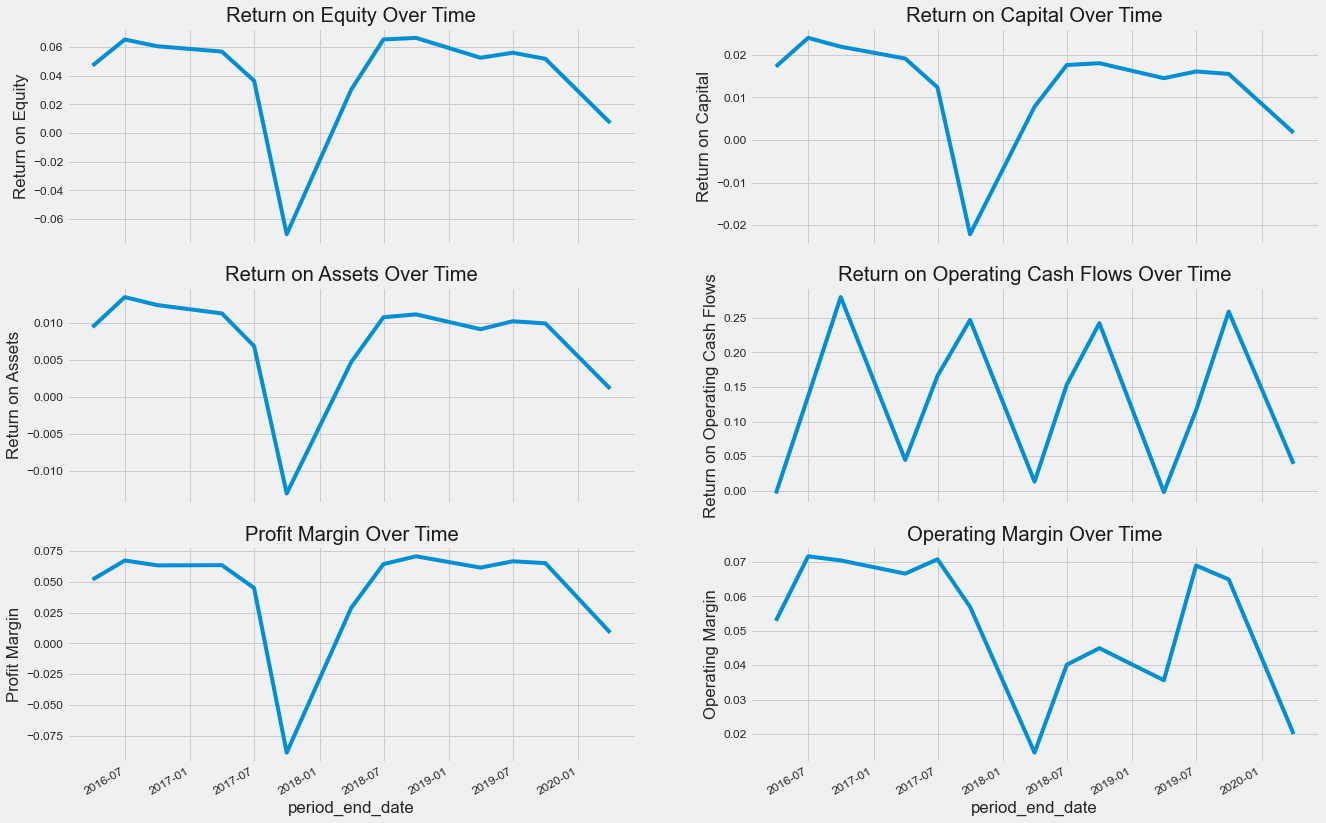

In [22]:
#visualization: 
fig, axs = plt.subplots(3,2,sharex= True, figsize= (20,15))
income.loc['2016':,'roe'].plot(ax = axs[0,0])
axs[0,0].set_ylabel('Return on Equity')
axs[0,0].set_title('Return on Equity Over Time') 

income.loc['2016':,'roc'].plot(ax= axs[0,1])
axs[0,1].set_ylabel('Return on Capital')
axs[0,1].set_title('Return on Capital Over Time')


income.loc['2016':,'roa'].plot(ax= axs[1,0])
axs[1,0].set_ylabel('Return on Assets')
axs[1,0].set_title('Return on Assets Over Time')


cf.loc['2016':,'rocf'].plot(ax= axs[1,1])
axs[1,1].set_ylabel('Return on Operating Cash Flows')
axs[1,1].set_title('Return on Operating Cash Flows Over Time')

income.loc['2016':,'profit_margin'].plot(ax= axs[2,0])
axs[2,0].set_ylabel('Profit Margin')
axs[2,0].set_title('Profit Margin Over Time')


income.loc['2016':,'operating_margin'].plot(ax= axs[2,1])
axs[2,1].set_ylabel('Operating Margin')
axs[2,1].set_title('Operating Margin Over Time')

plt.show()

## Profitability Over Time 

In [23]:
growth(income,['Return on Equity','Return on Capital','Return on Assets','Profit Margin','Operating Margin'],
      ['roe','roc','roa','profit_margin','operating_margin'])
growth(cf,['Return on Operating Cash Flows'],['rocf'])



The median Return on Equity was 5.262% with an average growth rate of -7.371%


The median Return on Capital was 1.609% with an average growth rate of -10.645%


The median Return on Assets was 0.998% with an average growth rate of -8.494%


The median Profit Margin was 6.333% with an average growth rate of -4.043%


The median Operating Margin was 5.698% with an average growth rate of -3.552%

Three Year Trend Progression: 



,roe,roc,roa,profit_margin,operating_margin
period_end_date,,,,,
2016-12-31,0.057714,0.021030,0.011830,0.060802,0.065006
2019-12-31,0.038407,0.010990,0.006835,0.041883,0.051534
2022-12-31,0.007130,0.001717,0.001160,0.008744,0.020086




The median Return on Operating Cash Flows was 14.355% with an average growth rate of 31.835%

Three Year Trend Progression: 



,rocf
period_end_date,
2011-12-31,0.084799
2014-12-31,0.137113
2017-12-31,0.147708
2020-12-31,0.117389


# Forecasting 

## Estimating Distributable Cash Flows 
<br> 

### Methods and Assumptions: 
<br>

Typically, we would want to first value the company based on reproduction cost of its tangible and intangible assets, in other words, we would look to adjust the balance sheet so that it reflects the amount of capital that would be required for a free-entry (no advantage) competitor to replicate the results produced by the company in question.

<br>
Secondly, we would attempt to uncover the earnings power value of a company, defined as: <br>

$$ EPV = \frac{Distributable Earnings}{Cost Of Capital} $$ 
    
The Cost of Capital here is referring to the capital required to sustain current levels of earnings and can be thought of as the risk or discount factor associated with the company. The earnings here would be calculated by starting at operating income, accounting for unusual expenses, adding back certain items as well as cash excess of operational needs. 

<br> 

Once we have estimated the above two we are able to determine what sort of competitive advantage (if any) the company has. The idea here is that if the EPV equals the asset reproduction cost then we enjoy no barriers-to-entry and without barriers-to-entry the company is only worth its asset reproduction cost and nothing more because of the lack of protection against profit-eroding competition (ie; any profit beyond capital levels would be removed via competition over time). If, however, we do enjoy a competitive advantage and assuming we maintain such advantage then we are in a position where we can generate earnings within a franchise and earnings within the franchise are protected and thus are sustainable. Such is the case when a company's EPV far exceeds its asset value. 


<br> 

For the sake of simplicity we will use free cash flows as our distributable earnings, defined as; <br>

$$ FCF = OCF - CAPEX $$ 

Which are our cash flows generated from operations less capital expenditures (we simply use PPE expenditures) 



<br> 



### Calculation 

In [24]:
fcf = cf['net_cash_provided_by__operating_activities'] + cf['expenditures_for_property']
fcf = (fcf / 3).resample('M').interpolate(method='from_derivatives')

### Visualization 

We observe the same seasonality as we expected, and we actually have a significant upward trend unlike our sales analysis.  

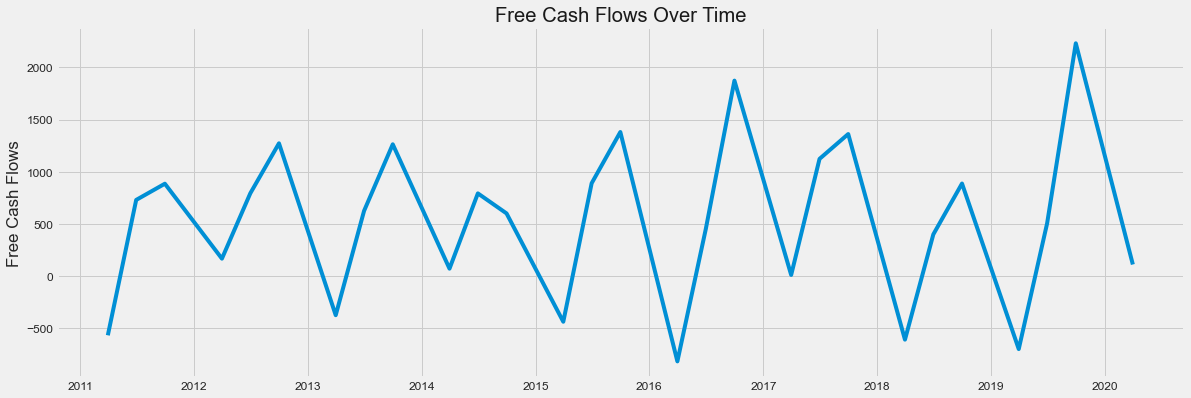

In [25]:
#plot 
plt.figure(figsize = (18,6))
plt.plot(fcf) 
plt.ylabel('Free Cash Flows')
plt.title('Free Cash Flows Over Time')
plt.show()

### Trend, Seasonality, and noise 
<br> 
GM's free cash flows are painting a completely different picture from our previous analysis:

1) We are not only observing an upward trend, but one which also seems to be exponential in nature 



2) Our seasonality is once again confirmed, and is confirmed much more clearly than in our sales which is expected due to their insulated nature. 



3) We see a slightly noisier signal with our free cash flows than we did our cash flows, a much noisier signal is to be expected since cash flows are inherently more volatile, so we actually have a picture thats telling us that cash flows are fairly stable in this case which is a great sign. 

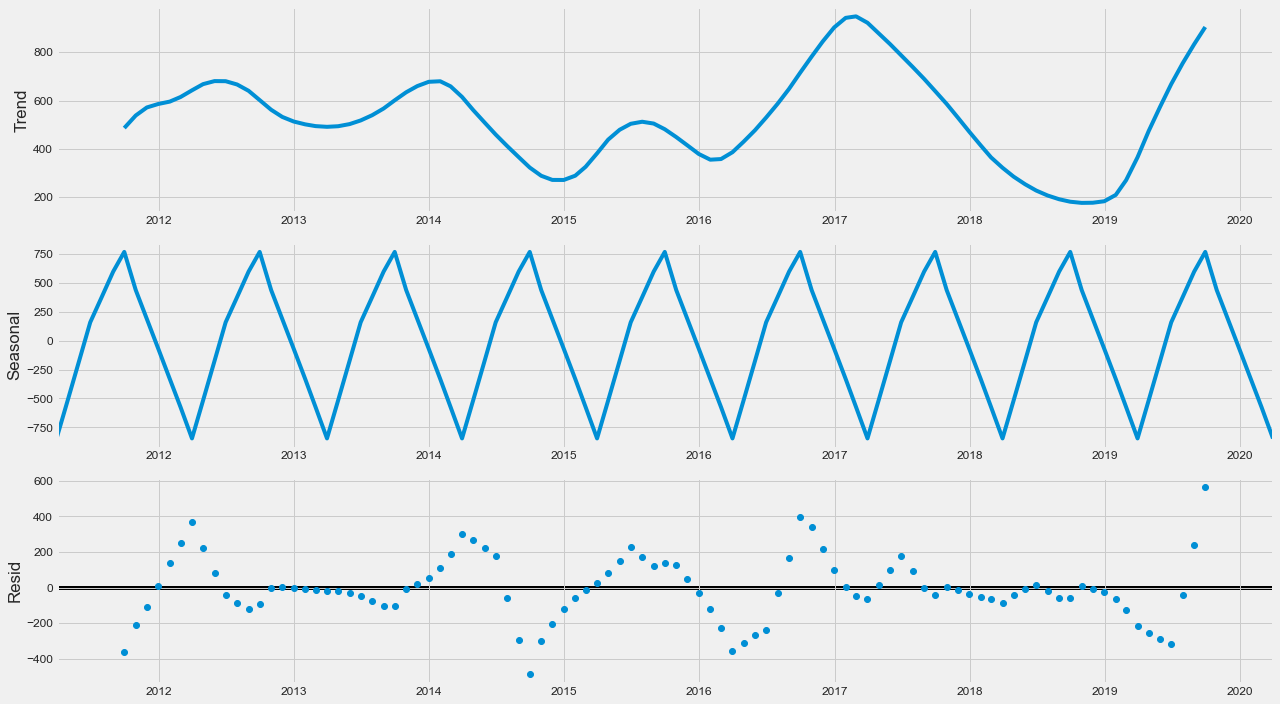

In [26]:
plt.rcParams['figure.figsize'] = 18,10
decompose = sm.tsa.seasonal_decompose(fcf,model='additive')
fig = decompose.plot(observed = False)
plt.show()

## Forecasting Cash Flows with ARIMA
<br> 
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.


ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in the data. 


We implement a grid search which will find the set of parameters minimizing the AIC (a measure of error). 


Our lowest AIC value was about 997 and so we use the corresponding parameters 


In [35]:
# Finding optimal parameters 
def grid_search():
    from collections import defaultdict
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    resul = defaultdict(list)
    aics = []
    for param in pdq:
        
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(fcf,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
                results = mod.fit()
    
                resul[results.aic] + [param,param_seasonal]
                aics.append((results.aic,param,param_seasonal))
        
            except: 
                continue
    return aics


In [37]:
param_grid = grid_search()

In [39]:
#params found 
[x for x in param_grid if x[0] == 991.7412341920065]

[(991.7412341920065, (1, 1, 1), (0, 1, 1, 12))]

### Modeling: 

We used the optimal parameters generated by our search to build our model. 


In [41]:
model = sm.tsa.statespace.SARIMAX(fcf,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  109
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -491.871
Date:                            Thu, 18 Jun 2020   AIC                            991.741
Time:                                    09:46:26   BIC                           1001.368
Sample:                                03-31-2011   HQIC                           995.606
                                     - 03-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6314      0.122      5.155      0.000       0.391       0.872
ma.L1          0.1564      0.270   

### Model diagnostics: 

Here we look into the results of our model and see if anything is out of the ordinary. 

Our model is not perfect, however our diagnostics suggest that our residuals are near normally distributed which will give us some confidence in our predictions 


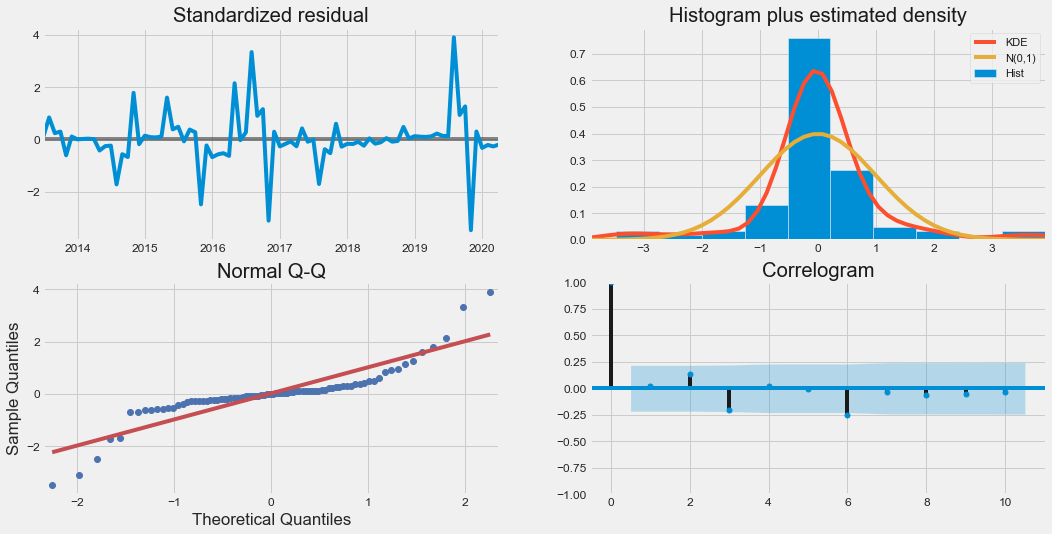

In [44]:
results.plot_diagnostics(figsize = (16,8))
plt.show()

## Validating Forecasts
<br> 
To understand the accuracy of our forecasts we will compare the predicted cash flows to the actual cash flows. Our predictions will go from 2018 to the end. 

1) We see that our observed values align with our forecasts exceptionally well. They are capturing both the seasonality at the start of the year and the taper off trend towards the end of the year 



2) We used the mean squared error (MSE) as our metric for assessing the forecasts, essentially measures the average of the squares of the errors. that is, the average squared difference between the estimated values and what is estimated. the smaller the MSE, the closer we are to finding the line of best fit.


3) Our MSE for the period was about 1000 and our root mean squared error was 102. This tells us that our model was able to forecast average monthly cash flows in the test set to within 105 million of our actual cash flows. Since our cash flows range from negative -816 million to over 2 billion, I would say the model is doing a fairly good job. 


 
    
    

In [45]:
#imports 
from sklearn.metrics import mean_squared_error

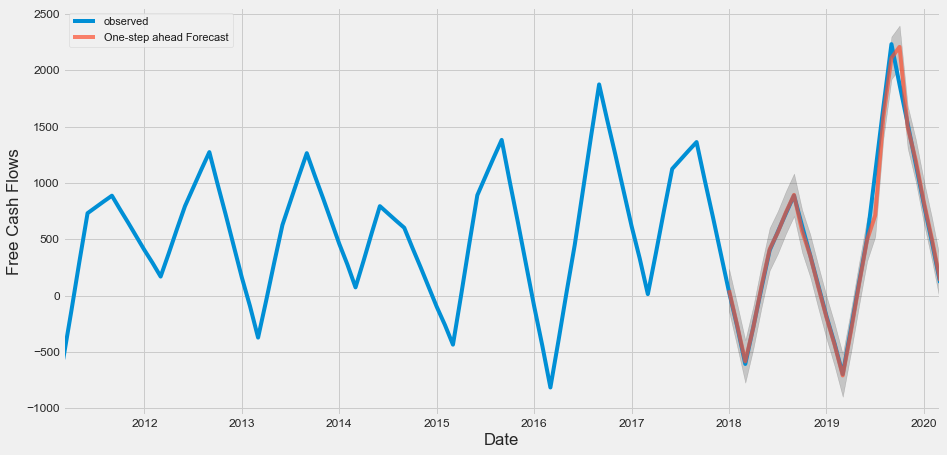

In [49]:
#visualizing observed vs. forecasts 
pred = results.get_prediction(start=pd.to_datetime('2018-01-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = fcf['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Free Cash Flows')
plt.legend()
plt.show()

In [58]:
#mse
forecasts = pred.predicted_mean
truth = fcf['2018':]

print(f'Our mean squared error is:  {mean_squared_error(truth,forecasts):.3f} \nOur Root Mean Squared error is: {mean_squared_error(truth,forecasts,squared=False):.3f}')

Our mean squared error is:  10548.924 
Our Root Mean Squared error is: 102.708


## Forecasting the future

Here we look into forecasting beyond the data we know and see how our forecasts do over time 


Our model clearly captures the seasonality and is being quite reasonable. We see that as we forecast further into the future, we naturally grow more uncertain about our predictions this is reflected by our model's confidence interval growing over time. Furthermore, I believe this to be one of the main problems of financial models like DCF, the idea of incorporating a terminal value into our valuation and having it account for 40-60% of our cash flows is simply unreasonable when our uncertainty pretty much explodes and overwhelms our predictions as we attempt to forecast 7 years into the future. 




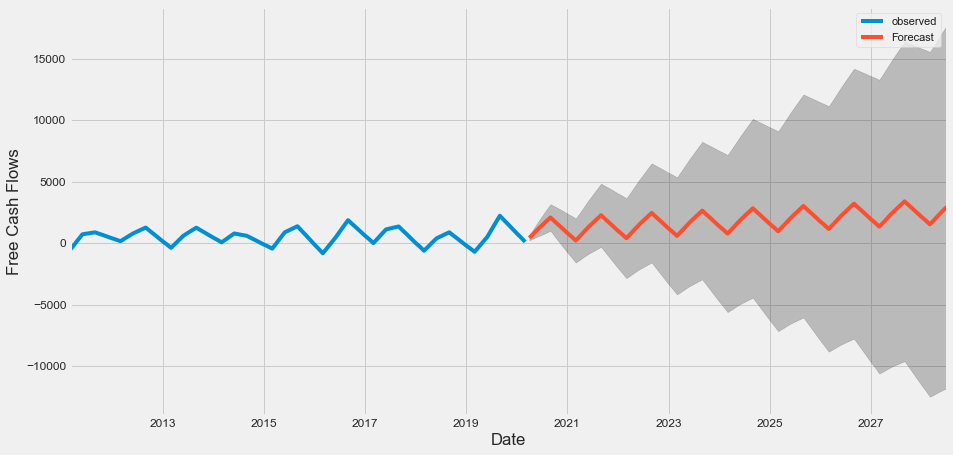

In [62]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = fcf.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Free Cash Flows')
plt.legend()
plt.show()

# Valuation 
<br> 

## Methodology: 

As mentioned above, I feel it would be unwise to simply use DCF or most of the financial models that I have seen in valuing the business, I believe this to be the case for the following reasons: 

1) Terminal Value: the confidence in our forecasts exponentially approach zero as we move beyond 5 years of forecasting, this is typical of even the most sophisticated models using high amounts of data. Thus, we will only look at 3-5 year forecasts 


2) The majority of financial models are parametric in that they assume a direct relationship between business factors like cash flows and the value of the business over time. Although the cash flows produced determine the value of the business, there are also a multitude of factors impacting our ability to generate said cash flows and this is inherent with any time-related forecasting. So, our focus should be on non-parametric models which flexibly fit the data and assume no specific growths or relationships beyond historical values. 


3) Most financial models not only assume parametric relationships but DCF, in particular assumes that cash flows actually grow at a constant rate over time. This adds tremendous uncertainty and is simply unfounded as there is no reason to believe that a business will simply grow over time as opposed to having years of growth, constancy, and even reduction which is more reflective of reality. 



<br> 

Typically my analysis would be more detailed as discussed above when estimating the value of the assets and the distributable earnings. Here, for the sake of simplicity, I will be simply using our three and five year predictions for future cash flows along with their confidence interval and I will discount those back at an appropriate discount to arrive at a range of values for the business. Although procedurally similar to DCF, this method is not burdened by the above problems and will allow us to pin down the uncertainty we have in our forecasts. 

## Calculation and Results: 
<br> 

We created forecasts for three and five year periods based on our model, the results were as follows: 


1) Our expected five-year present value is between 36-39 dollars 


2) Our expected three-year present value is around 26 dollars


3) Both valuation confidence intervals vary widely, but we can expect with a 95% likelihood that our three year upper bound will be around 70 and our five year to be around 113


4) The range of our interval could be optimized through further modeling, more data, and a more detailed and accurate earnings calculations. 


5) We can similarly value our company through its assets, book value, and dividends paid as they tend to have a lower rate of fluctuation. 


6) Our results do align with current and past market valuations and are consistent with our earlier analysis, hence we can feel comfortable using this as an initial valuation



In [129]:
def calc_val(ser,dr,n):
    discounts = [(1/(1 + dr))**i for i in range(1,n+1)]
    val = sum(ser[0:]*discounts)
    return val

In [126]:
#five year forecasts
forecst = results.get_forecast('2024')
five_year = forecst.summary_frame()
five_year = five_year.resample('1Y').sum()

In [130]:
five_year_val = five_year.agg(lambda x: calc_val(x,0.1,5))/1413
three_year_val = five_year[:"2022"].agg(lambda x: calc_val(x,0.1,3))/1413


In [144]:
print(f'''Five Year Forecast Valuation:\n Our expected value is: {five_year_val["mean"]:.3f}\n With a lower bound of: {max(0,five_year_val["mean_ci_lower"]):.3f}\n and an upper bound of: {five_year_val["mean_ci_lower"]:.3f}''')
print('\n')
print(f'''Three Year Forecast Valuation:\n Our expected value is: {three_year_val["mean"]:.3f}\n With a lower bound of: {max(0,three_year_val["mean_ci_lower"]):.3f}\n and an upper bound of: {three_year_val["mean_ci_lower"]:.3f}''')

Five Year Forecast Valuation:
 Our expected value is: 36.135
 With a lower bound of: 0.000
 and an upper bound of: -41.457


Three Year Forecast Valuation:
 Our expected value is: 25.982
 With a lower bound of: 0.000
 and an upper bound of: -18.497
